In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# ### Cell 1: 데이터 로드 및 전처리 ###

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print("Train/Test Shapes:")
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# Train/Validation 분리
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)
print("\nTrain/Validation Split Shapes:")
print(X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape)

/tmp/ipython-input-1489708326.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1489708326.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1489708326.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1489708326.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


Train/Test Shapes:
(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)

Train/Validation Split Shapes:
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6) (5881, 1) (1471, 1)


In [ ]:
# ### Cell 2: 변수 설정 ###
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
print(f"\nTimesteps: {n_timesteps}, Features: {n_features}, Outputs: {n_outputs}")


Timesteps: 128, Features: 9, Outputs: 6


In [ ]:
# ### Cell 3: 간단한 1D CNN (Sequential 모델) 정의 ###
# 기존의 복잡한 4-브랜치 함수형 모델 대신 단순한 순차 모델(Sequential)을 생성합니다.

simple_1d_cnn_model = Sequential()
simple_1d_cnn_model.add(Input(shape=(n_timesteps, n_features))) # 입력 형태: (128, 9)

# 첫 번째 컨볼루션 블록
simple_1d_cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
simple_1d_cnn_model.add(MaxPooling1D(pool_size=2))
simple_1d_cnn_model.add(Dropout(0.3))

# 두 번째 컨볼루션 블록
simple_1d_cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
simple_1d_cnn_model.add(MaxPooling1D(pool_size=2))
simple_1d_cnn_model.add(Dropout(0.3))

# Flatten 및 Dense 레이어
simple_1d_cnn_model.add(Flatten())
simple_1d_cnn_model.add(Dense(128, activation='relu'))
simple_1d_cnn_model.add(Dropout(0.5))

# 출력 레이어
simple_1d_cnn_model.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
simple_1d_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 요약 출력
simple_1d_cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518,918 (1.98 MB)

 Trainable params: 518,918 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5977 - loss: 0.9597 - val_accuracy: 0.8967 - val_loss: 0.3081
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8953 - loss: 0.2787 - val_accuracy: 0.9415 - val_loss: 0.1724
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9261 - loss: 0.1937 - val_accuracy: 0.9422 - val_loss: 0.1463
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9403 - loss: 0.1481 - val_accuracy: 0.9449 - val_loss: 0.1342
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9419 - loss: 0.1313 - val_accuracy: 0.9477 - val_loss: 0.1257
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9529 - loss: 0.1218 - val_accuracy: 0.9477 - val_loss: 0.1217
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9538 - loss: 0.1192 - val_accuracy: 0.9531 - val_loss: 0.1146
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9553 - loss: 0.1139 - val_accuracy: 

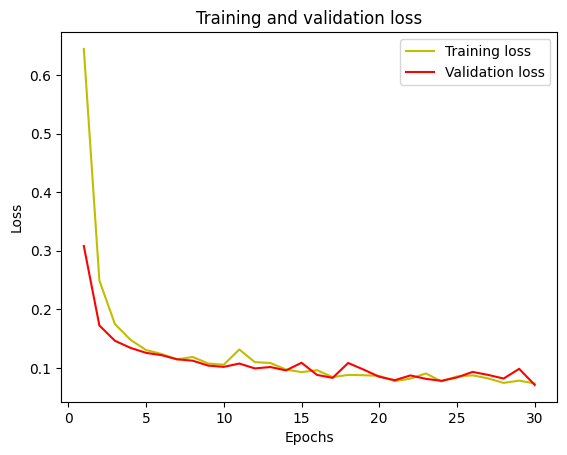

In [ ]:
# ###Cell 4: 단순화된 모델 훈련 ###
# 입력이 하나이므로 x=[X_train,X_train,X_train,X_train] 대신 x=X_train을 사용합니다.
# Cell 1에서 생성한 X_val, y_val_one_hot을 검증 데이터로 사용합니다.
model_history = simple_1d_cnn_model.fit(x=X_train, y=y_train_one_hot,
                                        epochs=30, batch_size=32,
                                        validation_data=(X_val, y_val_one_hot))


# ### Cell 5: 훈련 및 검증 손실 시각화 ###
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

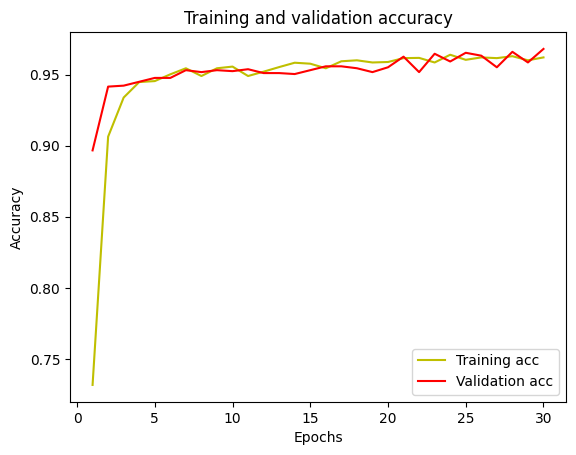

In [ ]:
# ### Cell 6: 훈련 및 검증 정확도 시각화 ###
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Confusion Matrix:
[[472   6  18   0   0   0]
 [  6 437  28   0   0   0]
 [  0   1 419   0   0   0]
 [  0  20   0 425  41   5]
 [  1   2   0 120 409   0]
 [  0  26   0   0   0 511]]

Accuracy Score:
0.9070240922972514

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.89      0.93      0.91       471
           2       0.90      1.00      0.95       420
           3       0.78      0.87      0.82       491
           4       0.91      0.77      0.83       532
           5       0.99      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



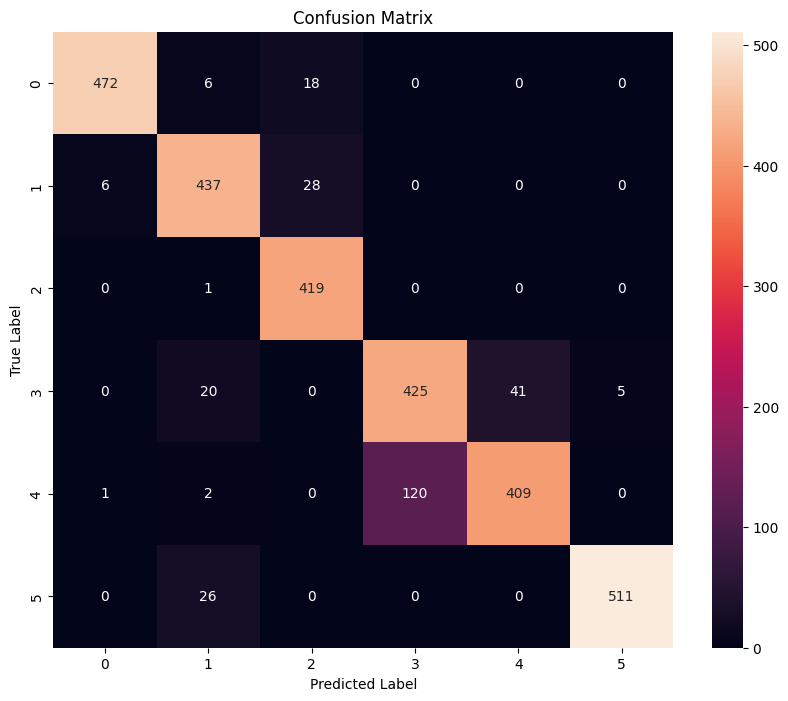

In [ ]:
# ###  Cell 7: 단순화된 모델 평가 ###
pred_probs = simple_1d_cnn_model.predict(testX)
pred = np.argmax(pred_probs, axis=-1)

cm = confusion_matrix(testy, pred)
print("\nConfusion Matrix:")
print(cm)

print("\nAccuracy Score:")
print(accuracy_score(testy, pred))

print("\nClassification Report:")
print(classification_report(testy, pred))

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=range(6), yticklabels=range(6))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()